 <h1><center>Data mining for a working Cas9 variant.</center></h1>



<div style="text-align: right">Lorenzo Federico Signorini, 09/08/2019</div>

<div style="text-align: right">Università degli studi di Trento</div>


In [1]:
# First created Thu Jul 11 09:51:15 CEST 2019
# This is a slightly older version, refer to the Cpf1 pipleine for a more updated version.
# Made by L-F-S
# At the University Of Trento, Italy

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from Bio import SeqIO
from IPython.display import display, HTML
sys.path.insert(0, '/home/lorenzo.signorini/cas_mining/utils/')
import filename_discrepancies
from Bio.Alphabet import generic_dna, generic_protein
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align.Applications import ClustalwCommandline
from Bio.Align import AlignInfo
from Bio import pairwise2
outpath="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/6mining/"
datadir="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/"


In [2]:
feature="Cas9"


# 1. Data:
## 1.1 load information about SGBs (species)

In [3]:
SGB_table=pd.read_csv("/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/S4Segata.csv", index_col=0)
SGB_table.shape

(4930, 10)

There are 4930 different species (SGBs) in the dataset, Let us print the 20 most abundant ones:

In [3]:
SGB_table.sort_values(by="# Reconstructed genomes", ascending=False).head(20)

SGB ID  # Reconstructed genomes  # Reference genomes uSGB  \
1490    4933                     3457                    8   No   
361     1836                     2983                   20   No   
672     2318                     2560                    2   No   
438     1934                     2169                   25   No   
1024    4285                     1925                    5   No   
339     1814                     1844                   15   No   
4281   15286                     1813                    0  Yes   
1444    4874                     1809                    4   No   
1181    4540                     1634                   10   No   
1559    5082                     1629                    4   No   
1486    4925                     1587                    3   No   
4305   15316                     1513                    1   No   
1005    4262                     1512                    5   No   
467     1965                     1432                    2   No   
3055   10068                     1413                 6193   No   
4655   17244                     1264                   25   No   
4659   17248                     1245                   59   No   
4294   15300                     1212                    1   No   
2801    9226                     1200                   32   No   
4258   15254                     1188                    0  Yes   

     Level of estimated taxonomy  \
1490                     Species   
361                      Species   
672                      Species   
438                      Species   
1024                     Species   
339                      Species   
4281                      Family   
1444                     Species   
1181                     Species   
1559                     Species   
1486                     Species   
4305                     Species   
1005                     Species   
467                      Species   
3055                     Species   
4655                     Species   
4659                     Species   
4294                     Species   
2801                     Species   
4258                      Family   

                                     Estimated taxonomy  \
1490  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
361   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   
672   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   
438   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   
1024  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
339   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   
4281  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
1444  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
1181  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
1559  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
1486  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
4305  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
1005  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
467   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   
3055  k__Bacteria|p__Proteobacteria|c__Gammaproteoba...   
4655  k__Bacteria|p__Actinobacteria|c__Actinobacteri...   
4659  k__Bacteria|p__Actinobacteria|c__Actinobacteri...   
4294  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   
2801  k__Bacteria|p__Verrucomicrobia|c__Verrucomicro...   
4258  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   

      Average distance from closest Reference Genome  \
1490                                        0.025725   
361                                         0.017564   
672                                         0.014071   
438                                         0.013706   
1024                                        0.024487   
339                                         0.017179   
4281                                        0.194245   
1444                                        0.022680   
1181                                        0.022782   
1559                                     

## 1.2 load information about Cas9s

In [4]:
cas9dataset=pd.read_csv("/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5caslocitable/known_Cas9_variants_table.csv", index_col=0)
cas9dataset.shape

(33978, 16)

There are 33978 Cas9s in the whole dataset of 154723 genomes.
This dataset was created following step 5, from the original Crisprcas_hits_table.csv. Every line is a different Cas9. Here is information about the sequence, the contig (piece of contiguous DNA in one genome),  other cas features on the same contig, and phylogenetical information, printed out for the first 10 Cas9s:

In [5]:
cas9dataset.columns

Index(['Seq ID', 'Seq Description', 'Seq', 'Contig', 'Genome Name', 'Study',
       'Sample Name', 'SGB ID', 'Pos', 'pilercr_CRISPR', 'minced_CRISPR',
       'prokka_cas1', 'prokka_cas2', 'uSGB', 'Level of estimated taxonomy',
       'Estimated taxonomy'],
      dtype='object')

In [6]:
cas9dataset.head(10)

Seq ID                                    Seq Description  \
0  EIBEGOMO_01279  EIBEGOMO_01279 CRISPR-associated endonuclease ...   
1  KBEGFPIJ_01435  KBEGFPIJ_01435 CRISPR-associated endonuclease ...   
2  OBHKLEMF_00864  OBHKLEMF_00864 CRISPR-associated endonuclease ...   
3  EPJEOPIP_01092  EPJEOPIP_01092 CRISPR-associated endonuclease ...   
4  AHBHJMAE_01497  AHBHJMAE_01497 CRISPR-associated endonuclease ...   
5  PPJNGKMK_00620  PPJNGKMK_00620 CRISPR-associated endonuclease ...   
6  AMIFCEHF_02229  AMIFCEHF_02229 CRISPR-associated endonuclease ...   
7  HBHGIHPK_01033  HBHGIHPK_01033 CRISPR-associated endonuclease ...   
8  FBOIKEJM_00490  FBOIKEJM_00490 CRISPR-associated endonuclease ...   
9  BNAIOCPL_01158  BNAIOCPL_01158 CRISPR-associated endonuclease ...   

                                                 Seq  \
0  MAEEIITDITIFGESKKMLRETLRKKFASCLDDEAIKKLSKLRYRD...   
1  MKNIVGLDLGTNSIGWAVVNGSVNDDGSEQLVKIQASGSRIIPMDA...   
2  MTKLNQPYGIGLDIGSNSIGFAVVDANSHLLRLKGETAIGARLFRE...   
3  MGDRKYNLGLDIGTSSIGFAAVDENNQPIRVKGKTAIGVRLFEEGK...   
4  MGYILGLDIGVASVGYAIIDENYNVLISGVRLFREGTAEENVARRG...   
5  MGKTHIIGVGLDLGGTYTGTFITSHPSDEAEHRDHSSAFTVVNSEK...   
6  MKTILGLDLGTTSIGWALVKEAEPFSDEKSEIVRLGVRVIPLTVDE...   
7  MKSIYEDLKKEKMVISMAKELHFTSKDMPISDFDRMELKGRIETNP...   
8  MILSTQKYIIDTKGCNMKYKLGLDLGSTSLGWAIVELNEKDTPIRL...   
9  MDKKYYIGADIGTESVGWAVTDEDYNILKARGRELWGSYLFDKAES...   

                              Contig                           Genome Name  \
0  NODE_1073_length_1994_cov_2.17225   AsnicarF_2017__MV_FEI4_t1Q14__bin.1   
1   NODE_45_length_75974_cov_38.2495   AsnicarF_2017__MV_FEI4_t1Q14__bin.4   
2   NODE_51_length_94666_cov_13.1517   AsnicarF_2017__MV_FEI4_t2Q15__bin.2   
3   NODE_70_length_82951_cov_19.4828   AsnicarF_2017__MV_FEI4_t2Q15__bin.5   
4  NODE_123_length_29049_cov_29.8501  AsnicarF_2017__MV_FEI5_t1Q14__bin.12   
5  NODE_30_length_116148_cov_68.0265   AsnicarF_2017__MV_FEI5_t2Q14__bin.2   
6  NODE_175_length_31817_cov_9.16545   AsnicarF_2017__MV_FEM1_t1Q14__bin.6   
7  NODE_4986_length_3564_cov_6.73668   AsnicarF_2017__MV_FEM2_t1Q14__bin.2   
8   NODE_9_length_125774_cov_10.3523  AsnicarF_2017__MV_FEM2_t1Q14__bin.30   
9  NODE_2411_length_6235_cov_4.42071  AsnicarF_2017__MV_FEM2_t1Q14__bin.32   

           Study    Sample Name  SGB ID            Pos  \
0  AsnicarF_2017  MV_FEI4_t1Q14    6939        141 608   
1  AsnicarF_2017  MV_FEI4_t1Q14    1814    32341 36870   
2  AsnicarF_2017  MV_FEI4_t2Q15    7144    25358 29455   
3  AsnicarF_2017  MV_FEI4_t2Q15    7168    27653 31726   
4  AsnicarF_2017  MV_FEI5_t1Q14    6939     8232 11426   
5  AsnicarF_2017  MV_FEI5_t2Q14    9262    30463 34749   
6  AsnicarF_2017  MV_FEM1_t1Q14    2230    18359 22555   
7  AsnicarF_2017  MV_FEM2_t1Q14    1024        75 1775   
8  AsnicarF_2017  MV_FEM2_t1Q14   17322  107624 111007   
9  AsnicarF_2017  MV_FEM2_t1Q14   14099       532 4515   

                    pilercr_CRISPR  \
0                              NaN   
1  [('ID=CRISPR1', '40172', '12')]   
2  [('ID=CRISPR1', '23272', '22')]   
3   [('ID=CRISPR1', '24497', '3')]   
4  [('ID=CRISPR1', '13059', '23')]   
5   [('ID=CRISPR1', '29853', '6')]   
6  [('ID=CRISPR2', '25256', '18')]   
7                              NaN   
8  [('ID=CRISPR1', '113006', '6')]   
9                              NaN   

                                       minced_CRISPR  \
0                                                NaN   
1                          [('.', '39283', '40172')]   
2                          [('.', '21587', '23272')]   
3                          [('.', '24197', '25552')]   
4                          [('.', '11506', '13060')]   
5  [('.', '29462', '29925'), ('.', '36897', '3764...   
6                          [('.', '23902', '25256')]   
7                                                NaN   
8                        [('.', '112378', '113006')]   
9                                                NaN   

                                   prokka_cas1  \
0                

## 1.3. Initial Cas9 lengths distribution

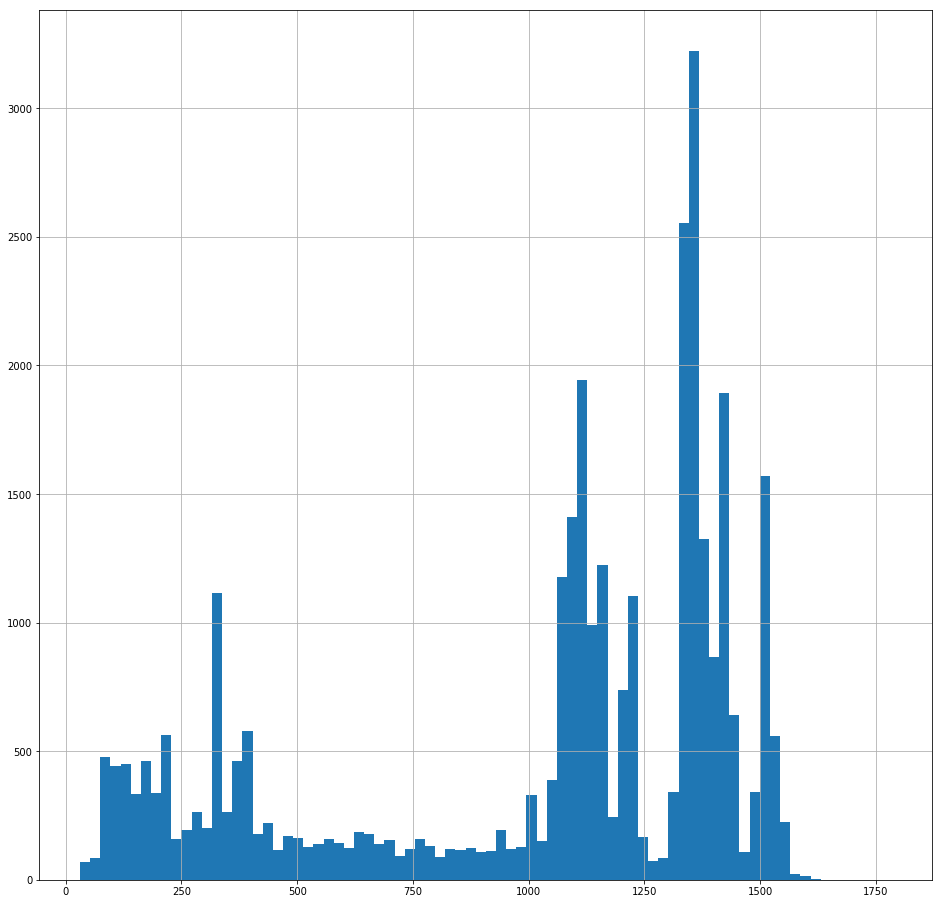

In [167]:
counts=cas9dataset["Seq"].str.count("")
counts.hist(bins=80, figsize=(20*0.8,20*0.8))

In [190]:
counts.max()

1784

# 2. Data filtering: Extract a list of the shortest working cas9 from most abundant and most unknown genomes.

## 2.1 Filter by: active locus
An active locus is defined by having at least 1 CRISPR array, 1 Cas1, 1 Cas2, and 1 effector Cas

In [6]:
# Checking that the next step actually does work properly:
# If there are no NaNs values in columns ["Estimated taxonomy","Level of estimated taxonomy", "SGB ID",
#                                            "Sample Name", "Study", "Genome Name", "Contig", "Seq", 
#                                            "Seq Description", "Seq ID"],
# then, it returns True
temp=cas9dataset[cas9dataset.isna().any(axis=1)]
temp[temp["Estimated taxonomy"]==None].shape==temp[temp["Level of estimated taxonomy"]==None].shape==\
temp[temp["uSGB"]==None].shape==temp[temp["SGB ID"]==None].shape==temp[temp["Sample Name"]==None].shape==\
temp[temp["Study"]==None].shape==temp[temp["Genome Name"]==None].shape==temp[temp["Contig"]==None].shape==\
temp[temp["Seq"]==None].shape==temp[temp["Seq Description"]==None].shape==temp[temp["Seq ID"]==None].shape==\
(0,16)

True

In [7]:
#Drop Nan rows
activecas9s=cas9dataset.dropna(how="any")
print(activecas9s.shape)

(18875, 16)


There are 18875 active loci. Let us print the lengths distribution of cas9 in these loci:

## 2.2 Filter by: working active locus
A working locus is defined by being an active locus with a Cas9 of a length falling within the peak of the distribution

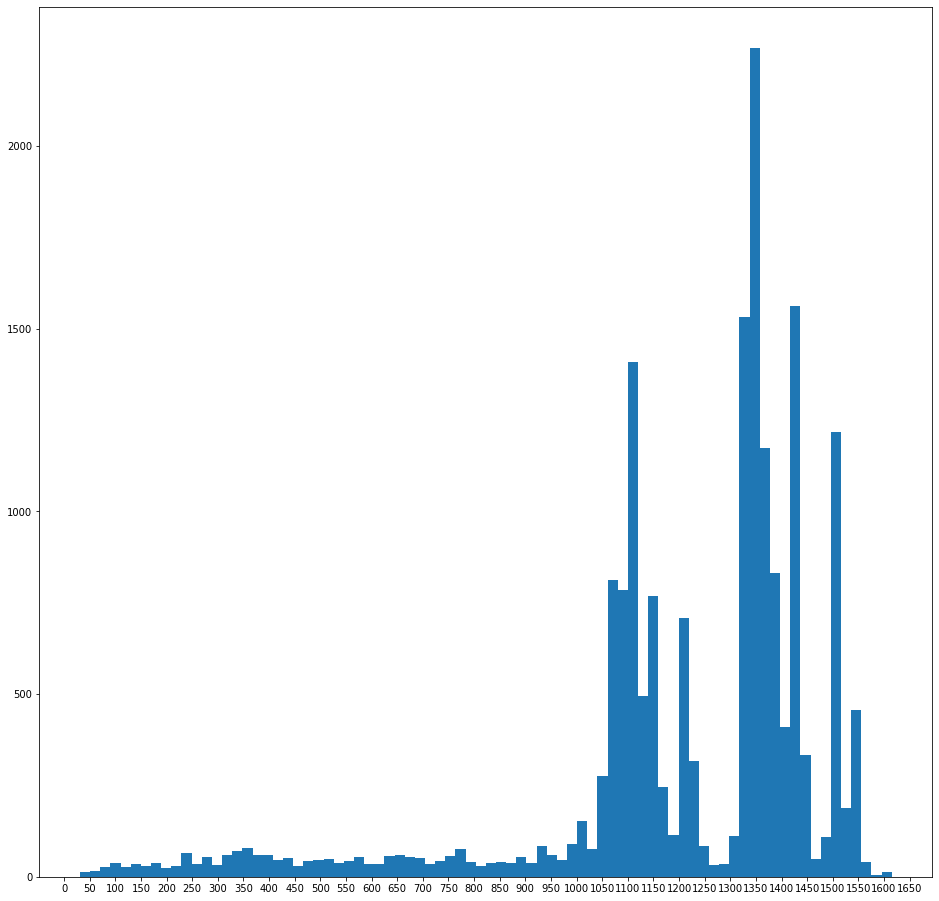

In [8]:
activecas9counts=activecas9s["Seq"].str.count("")
plt.figure(figsize=(20*0.8,20*0.8))
plt.hist(activecas9counts ,bins=80)
plt.xticks(np.arange(0, 1700, step=50))
print()

The length intreval where there seems to be a working protein is around (1050,1170) , (1330,1450) and maybe (1500,1580). We shall define these intrevals as working lengths.

## 2.3-2.4 Filter by: sequence length of 949-1099 amino acid, unknown SGB
An unknown SGB is an SGB with no reference genome in literature.

In [9]:
sorted_activecas9counts=activecas9s["Seq"].str.count("").sort_values()
working_intreval=sorted_activecas9counts[sorted_activecas9counts>=949]
working_intreval=working_intreval[working_intreval<=1099]
active_working_cas9s=activecas9s.loc[working_intreval.index]
active_working_unknwon_cas9s=active_working_cas9s[active_working_cas9s.uSGB=="Yes"]
active_working_unknwon_cas9s.shape

(628, 16)

There are 628 active and working Cas9s from unknown species.

## 13/12/2019 additional filtering only by completely unknown SGB, ie sgb with no phylum


In [30]:
active_working_unknwon_cas9s=active_working_unknwon_cas9s[active_working_unknwon_cas9s["Estimated taxonomy"]=="-"]
active_working_unknwon_cas9s.shape

(142, 16)

## 2.5 Filter by: most abundant SGB 

Let us check which SGBs are the most abundant among the Cas loci we have filtered so far.

In [22]:
genomes_in_SGB={}
for n, cas9series in active_working_unknwon_cas9s.iterrows():
    if not cas9series["SGB ID"] in genomes_in_SGB.keys():
         genomes_in_SGB[cas9series["SGB ID"]]=[]
    genomes_in_SGB[cas9series["SGB ID"]].append(cas9series["Genome Name"])
genomes_in_SGB2={SGB:len(np.unique(genomenames)) for (SGB, genomenames) in genomes_in_SGB.items()}

In [23]:
SGB_abundance_in_dataset=pd.Series(genomes_in_SGB2, index=genomes_in_SGB.keys(), name="# Genomes with act. wrk. cas9").sort_values(ascending=False).rename_axis('SGB ID')

In [32]:
SGB_rel_ab_in_dataset=pd.DataFrame(SGB_table[SGB_table["SGB ID"].isin(SGB_abundance_in_dataset.index)][["SGB ID","# Reconstructed genomes"]])
SGB_abundance=pd.DataFrame(SGB_abundance_in_dataset).merge(SGB_rel_ab_in_dataset, left_on='SGB ID', right_on='SGB ID')
SGB_abundance["Genomes relative abundance"]=SGB_abundance["# Genomes with act. wrk. cas9"]/SGB_abundance["# Reconstructed genomes"]
SGB_abundance.head(15)

SGB ID  # Genomes with act. wrk. cas9  # Reconstructed genomes  \
0     9340                            105                      242   
1    15299                             51                       99   
2     8767                             34                       71   
3    15095                             22                       70   
4     9281                             17                      146   
5     9710                             16                       28   
6     9311                             14                       22   
7     8769                             14                       18   
8    14454                             11                       83   
9     8774                             10                       25   
10   15286                             10                     1813   
11    9280                             10                      145   
12    9307                              9                       28   
13    4329                              9                       34   
14   14370                              9                       44   

    Genomes relative abundance  
0                     0.433884  
1                     0.515152  
2                     0.478873  
3                     0.314286  
4                     0.116438  
5                     0.571429  
6                     0.636364  
7                     0.777778  
8                     0.132530  
9                     0.400000  
10                    0.005516  
11                    0.068966  
12                    0.321429  
13                    0.264706  
14                    0.204545

All SGBs have a pretty high relative abundance, except for 15286 a, 14454 and 9280. And 8769 does not make any sense.Check that later.

Let us keep all the loci from the SGBs with 10 or more genomes (each one of these genomes contains a working, active cas9 and belongs to the same species), that is, the first 12 SGBs.


But, first, let's check whether all samples are coming from different datasets:

In [31]:
#returns SGBs with samples that only come from one dataset, if any.
for SGB in SGB_abundance_in_dataset.head(15).index:
    first_dataset=True
    diff=False
    for ind, Cas9 in active_working_unknwon_cas9s.iterrows():
        if Cas9["SGB ID"]==SGB:
            dataset=Cas9["Study"]
            if not first_dataset:
                if dataset != temp_unique_dataset:
                    diff=True
            else:
                temp_unique_dataset=dataset
                first_dataset=False
    if not diff:
        print("SGB",SGB,"genomes all come from dataset",dataset)

                

SGB 9710 genomes all come from dataset HMP_2012


This might indicate a certain degree of replication in the data for that dataset.

# 3 Data Clustering


(chosen SGBs v1: 9340, 15299, 8767, 15095, 8769, 9710, 9281, 9311, 14454, 4329, 8774, 15286, 8768
v2: 9324, 9243, 17319, 6927, 8770,9359
)

## 9/1/2020 update: no clustering of identical sequences: skip 3.1 and just do 1 clustering, but keep original sequences, so that se nn trovo tracr in step 7, posso trace back e andare a trovarle


In [37]:
selected_SGBs=[9340, 15299, 8767, 15095, 8769, 9710, 9281, 9311, 14454, 4329, 8774, 15286, 8768]
alignments=[]
for SGB in selected_SGBs:
    current_SGB=active_working_unknwon_cas9s[active_working_unknwon_cas9s["SGB ID"]==SGB]
    
    for index, row in current_SGB.iterrows():
        tempseq=SeqRecord(Seq(row.Seq), id=str(row["SGB ID"])+"__"+row["Seq ID"]+"__"+row["Genome Name"], description=row["Genome Name"]+"__"+row["Seq ID"]+"__"+str(row["SGB ID"]))
        alignments.append(tempseq)


filename_for_fasta_with_all_sequences=outpath+feature+"/"+feature+"_sequences_949_1099_uSGB_active"
SeqIO.write(alignments, filename_for_fasta_with_all_sequences+".faa", "fasta")


329

## 3.1 Cluster together identical sequences in the same SGB

In [90]:
def seq_getter(s): return str(s.seq)
cons_table_949_1048=""
selected_SGBs=[9340, 15299, 8767, 15095, 8769, 9710, 9281, 9311, 14454, 4329, 8774, 15286, 8768] # [9324, 9243, 17319, 6927, 8770,9359] #
for SGB in selected_SGBs:
    current_SGB=active_working_unknwon_cas9s[active_working_unknwon_cas9s["SGB ID"]==SGB]
    alignments=[]
    for index, row in current_SGB.iterrows():
        tempseq=SeqRecord(Seq(row.Seq), id=str(row["SGB ID"])+"__"+row["Seq ID"]+"__"+row["Genome Name"], description=row["Genome Name"]+"__"+row["Seq ID"]+"__"+str(row["SGB ID"]))
        alignments.append(tempseq)

    #write fasta for every SGB
    filename="SGB"+str(SGB)
    SeqIO.write(alignments, outpath+filename+".faa", "fasta")
    
    #read from that fasta and group identical sequences somehow
    fastafile=outpath+filename+".faa"
    records = list(SeqIO.parse(fastafile,'fasta'))    
    records.sort(key=seq_getter)
    n=0
    for seq,equal in groupby(records, seq_getter):
        ids = ';'.join(s.id for s in equal)
        N=ids.count(';')+1
        
        line=">"+ids+";length"+str(len(seq))+";#sequences"+str(N)+"\n"+seq+"\n"
        cons_table_949_1048+=line
filename2= "949_1099_aa_Cas9_sequences_from_active_loci_from_"+str(len(selected_SGBs))+"_most_abundant_most_unknown_species_identical"  
f=open(outpath+filename2+".faa","w")
f.write(cons_table_949_1048)
f.close()
sequences=list(SeqIO.parse(outpath+filename2+".faa",'fasta'))
print("There are", len(sequences),"unique sequences in ",len(selected_SGBs)," SGBs")# clusters","("+str(len(without_9710))+" without 9710 SGB) at "+identity_score+" identity.")


There are 23 unique sequences in  6  SGBs


## 3.3 Sequences clustering
Cluster together sequences of up to 90% similarity, and extract one representative sequence for each cluster.
Different clustering algorithms are available,the one that works the easiest was fast uclust https://drive5.com/usearch/manual/uclust_algo.html. Uclust performs centroid-based clustering and returns the centroid of each cluster as representative sequence.

```
usearch -cluster_fast 949_1099_aa_Cas9_sequences_from_active_loci_from_12_most_abundant_most_unknown_species_identical.faa -id 0.90 -centroids 9aCsfalf1musi_centroid90.faa -uc clusters.uc

```

In [39]:
identity_score="97"
print("usearch -cluster_fast "+filename_for_fasta_with_all_sequences+".faa -id 0.97 -centroids "+outpath+feature+"/"+identity_score+"_clusters/"+"9aCsfalf1musi_centroid97_moreunknown.faa -uc clusters.uc -strand both -msaout 9aCsfalf1musi_MSAall97_moreunknown.faa ")

usearch -cluster_fast /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5caslocitable/out/Cas9/Cas9_sequences_949_1099_uSGB_active.faa -id 0.97 -centroids /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5caslocitable/out/Cas9/97_clusters/9aCsfalf1musi_centroid97_moreunknown.faa -uc clusters.uc -strand both -msaout 9aCsfalf1musi_MSAall97_moreunknown.faa 


uclust output parsing

In [92]:
for identity_score in ["97"]:#["90", "93","95","97", "99"]:
    without_9710, without_8769, without_15286, without_14454, without_9280, without_sketcy_sgbs=[], [],[],[],[],[]
    n_cluster_per_SGB=[]
    for record in SeqIO.parse(outpath+feature+"/"+identity_score+"_clusters/9aCsfalf1musi_centroid"+identity_score+"_moreunknown.faa",'fasta'):
        if not (record.id.startswith("9710") or record.id.startswith("8769") or record.id.startswith("15286") or record.id.startswith("14454") or record.id.startswith("9280")):
            without_sketcy_sgbs.append(SeqRecord(record.seq, id=record.id, description=record.description))
       
        SGBsnames=[oneid[:6].rstrip("__") for oneid in record.id.split(";")]
        SGBsnames=np.unique(SGBsnames) 
        SGBsnames=",".join(SGBsnames)
        n_cluster_per_SGB.append(SGBsnames)
    print("There are", len(n_cluster_per_SGB), "sequence clusters","("+str(len(without_sketcy_sgbs))+" without SGBs 9710,8769, 15286,14454, 9280) at "+identity_score+" identity.")
    print("SGB(s)\t# Sequence clusters\n---------------------------")
    print(pd.Series(n_cluster_per_SGB).value_counts(),"\n")


There are 7 sequence clusters (7 without SGBs 9710,8769, 15286,14454, 9280) at 97 identity.
SGB(s)	# Sequence clusters
---------------------------
#seque,9324,length     2
#seque,6927,length     1
#seque,9359,length     1
#seque,9243,length     1
#seque,17319,length    1
#seque,8770,length     1
dtype: int64 



## 3.4 (16/09/2019) MSA withing clusters:

In [69]:
identity_score='97'
clusters="9aCsfalf1musi_centroid"+identity_score+".faa"
all_sequences_file='949_1099_aa_Cas9_sequences_from_active_loci_from_12_most_abundant_most_unknown_species_identical.faa'
tot=0
n=1
for record in SeqIO.parse(outpath+identity_score+"_clusters/9aCsfalf1musi_centroid"+identity_score+".faa",'fasta'):
   # collect all sequences from that cluster in this file
    print("recovering sequences from cluster n", n)
    alignname="9aCsfalf1musi_clusters"+identity_score+"_all_sequences_from_cluster_"+str(n)

    seqnames=[oneid for oneid in record.id.split(";")]
    seqnames=seqnames[:-2]
    
    alignments=[]
    print(seqnames)
    for name in seqnames:
        tot+=1
        SGB=name[:6].rstrip("__") 
  #      print(SGB)
        with open(outpath+"SGB"+SGB+".faa", "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if name in record.id: 
             #       print("WWWWWWWEEEEEEEEEEEEEEE", name)
               #     print(record.id)
                    tempseq=SeqRecord(record.seq, id=record.id)
                    alignments.append(tempseq)
    print(len(seqnames),len(alignments))
    
 #   SeqIO.write(alignments, outpath+"97_clusters/"+alignname+".faa", "fasta")
    
    cline= ClustalwCommandline("clustalw", infile=outpath+"97_clusters/"+alignname+".faa", outfile=outpath+"97_clusters/"+alignname+".aln")
#    print(cline)
    
    n+=1

print("total amount of sequences= ", tot)

recovering sequences from cluster n 1
['8767__CPMHNJAN_01529__LiJ_2014__O2.UC47-1__bin.10']
1 1
recovering sequences from cluster n 2
['9340__OCELCMFD_00538__LiJ_2014__MH0381__bin.14', '9340__PGIBIKKF_00883__Bengtsson-PalmeJ_2015__TRAVELRES19__bin.48', '9340__OJIFKKEH_00952__NielsenHB_2014__MH0142__bin.54', '9340__DCBFKDAH_01299__LiJ_2014__O2.UC35-1__bin.24', '9340__JCLLJKEO_01173__LeChatelierE_2013__MH0142__bin.47', '9340__NBMJNKHO_01298__LiJ_2014__V1.FI20__bin.1', '9340__FIMCNEOK_00718__LiJ_2014__V1.CD46-0__bin.16', '9340__JKODOPGL_01579__ZeeviD_2015__PNP_Main_272__bin.34']
8 8
recovering sequences from cluster n 3
['15095__NJIFCGIA_00127__LiuW_2016__SRR3993002__bin.69']
1 1
recovering sequences from cluster n 4
['9281__LFLJBGAC_00085__ChengpingW_2017__AS103raw__bin.27', '9281__DPAFGDNC_01834__ChengpingW_2017__AS6raw__bin.40']
2 2
recovering sequences from cluster n 5
['15299__MEAMCIMP_00790__XieH_2016__YSZC12003_37308R1__bin.5', '15299__NCDIHEEA_00022__XieH_2016__YSZC12003_37282__bi

# 4 MSalignment with known sequences

perform pairwise alignment of cluster centroids with known workingcas9s. And visualize them nicely.

In [2]:
# build a fasta file of the things to be aligned against

In [93]:
# merge the fastas together
identity_score='97'
clusters="9aCsfalf1musi_centroid"+identity_score+"_moreunknown.faa"
ref_fasta="uniprot_working_Cas9s.fasta"
alignname="MSA_clusters"+identity_score+"_and_ref_and_unknown"

In [96]:
alignments=[]
for row in list(SeqIO.parse(outpath+feature+"/"+identity_score+"_clusters/"+clusters,'fasta'))+list(SeqIO.parse(outpath+feature+"/"+ref_fasta, 'fasta')):
    tempseq=SeqRecord(row.seq, id=row.id)
    alignments.append(tempseq)

SeqIO.write(alignments, outpath+feature+"/"+identity_score+"_clusters/"+alignname+".faa", "fasta")

15

In [95]:
#alignname="9aCsfalf1musi_centroid95.faa" #TODO temp
cline= ClustalwCommandline("clustalw", infile=outpath+feature+"/"+identity_score+"_clusters/"+alignname+".faa", outfile=outpath+feature+"/"+identity_score+"_clusters/"+alignname+".aln")
print(cline)
os.system(str(cline))

clustalw -infile=/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5caslocitable/out/Cas9/97_clusters/MSA_clusters97_and_ref_and_unknown.faa -outfile=/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5caslocitable/out/Cas9/97_clusters/MSA_clusters97_and_ref_and_unknown.aln


32512

In [7]:
#from Bio import AlignIO
#identity_score='95'
#for record in SeqIO.parse(outpath+"9aCsfalf1musi_centroid"+identity_score+".faa", "fasta"):
 #   for referencecas9record in SeqIO.parse(outpath+"uniprot_working_Cas9s.fasta", "fasta"):
  #      alignments = pairwise2.align.globalxx(record.seq, referencecas9record.seq)
        #print(pairwise2.format_alignment(*alignments[0]))
      #  print("##########################################################################")
   #     AlignIO.write(alignments, outpath+"test_aln","fasta"),
            

TypeError: not all arguments converted during string formatting

# Build maximum likelihood tree out of the multiple sequence alignments

In [1]:
# go on your laptop open MEGA and build it

# Build a score matrix

In [3]:
from Bio import pairwise2
import  Bio.SubsMat.MatrixInfo as mx

In [7]:
help(mx)

Help on module Bio.SubsMat.MatrixInfo in Bio.SubsMat:

NAME
    Bio.SubsMat.MatrixInfo - Substitution matrices for use in alignments, etc.

DESCRIPTION
    The information on this page was originally obtained from Dr. Gerhard Vogt's
    page http://www.embl-heidelberg.de/~vogt/matrices/mlist1.html (dead link),
    and was extracted using a script.
    
    You can view an archive copy of this webpage from 1999 here;
    https://web.archive.org/web/19991014010917/http://www.embl-heidelberg.de/%7Evogt/matrices/mlist1.html

DATA
    available_matrices = ['benner6', 'benner22', 'benner74', 'blosum100', ...
    benner22 = {('A', 'A'): 2.5, ('A', 'C'): -1.2, ('A', 'P'): 0.8, ('A', ...
    benner6 = {('A', 'A'): 2.5, ('A', 'C'): -1.7, ('A', 'P'): 1.1, ('A', '...
    benner74 = {('A', 'A'): 2.4, ('A', 'C'): 0.3, ('A', 'P'): 0.4, ('A', '...
    blosum100 = {('A', 'A'): 5, ('B', 'A'): -3, ('B', 'B'): 4, ('B', 'C'):...
    blosum30 = {('A', 'A'): 4, ('B', 'A'): 0, ('B', 'B'): 5, ('B', 'C'): -...


In [4]:
#scorematrix=pd.DataFrame()
scrmtrx=[]
cols=[]
for ref_cas9 in SeqIO.parse(outpath+"uniprot_working_Cas9s.fasta", "fasta"):
    ref_cas9_len=len(ref_cas9.seq)
    print(">>>>>>>>>>>>>>>>>>>>>>>>REF: "+ref_cas9.id+" ",ref_cas9_len)
    cols.append(ref_cas9.id)
    scores=[]
    index=[] #slight redundancy, this gets called multiple times, ma chissene
    for mg_cas9 in SeqIO.parse(outpath+"/97_clusters/9aCsfalf1musi_centroid97.faa", "fasta"):
        
        #aligner = Align.PairwiseAligner()
        #aligner.substitution_matrix = mx.gonnet
        #aligner.open_gap_score = -10
        #aligner.extend_gap_score = -0.1
        #alignments = aligner.align(mg_cas9.seq, ref_cas9.seq)
        alignments = pairwise2.align.globalds(mg_cas9.seq, ref_cas9.seq, mx.gonnet, -10, -0.1)
        
        for ind, (align1, align2, score, begin, end) in enumerate(alignments):
            filename = outpath+"/97_clusters/pairwise_alignments_of_centroids_vs_refs/PA_" + ref_cas9.id + "_vs_" + mg_cas9.id[:10] + ".aln"
            with open(filename, "w") as handle:
                handle.write(">%s\n%s\n>%s\n%s\n" % (mg_cas9.id, align1, ref_cas9.id, align2))
        print("Done")
        
        #AlignIO.write(alignments ,outpath+"/97_clusters/pairwise_alignments_of_centroids_vs_refs/" + ref_cas9.id + "_vs_" + mg_cas9.id + ".aln", "clustal")
        
        score=alignments[0][2]
        scores.append(score/ref_cas9_len)
 #       scorematrix.at[mg_cas9.id, ref_cas9.id]=score/ref_cas9_len
#        print("SCORE= ", score/ref_cas9_len)
        index.append(mg_cas9.id)
  #  scorematrix[ref_cas9.id]=pd.Series(scores)
    scrmtrx.append(scores)
#scorematrix.index=index

>>>>>>>>>>>>>>>>>>>>>>>>REF: sp|Q99ZW2|CAS9_STRP1  1368
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
>>>>>>>>>>>>>>>>>>>>>>>>REF: sp|J7RUA5|CAS9_STAAU  1053
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
>>>>>>>>>>>>>>>>>>>>>>>>REF: sp|Q0P897|CAS9_CAMJE  984
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
>>>>>>>>>>>>>>>>>>>>>>>>REF: sp|G3ECR1|CAS9_STRTR  1409
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
>>>>>>>>>>>>>>>>>

In [20]:
outpath+"/97_clusters/pairwise_alignments_of_centroids_vs_refs/PA_" + ref_cas9.id + "_vs_" + mg_cas9.id + ".aln"

'/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5caslocitable/out//97_clusters/pairwise_alignments_of_centroids_vs_refs/PA_sp|Q0P897|CAS9_CAMJE_vs_9340__AKIPNPCL_00899__CosteaPI_2017__SID713A009-11-90-0__bin.81;length1005;#sequences1.aln'

In [15]:
help(AlignIO.ClustalIO)

Help on module Bio.AlignIO.ClustalIO in Bio.AlignIO:

NAME
    Bio.AlignIO.ClustalIO - Bio.AlignIO support for "clustal" output from CLUSTAL W and other tools.

DESCRIPTION
    You are expected to use this module via the Bio.AlignIO functions (or the
    Bio.SeqIO functions if you want to work directly with the gapped sequences).

CLASSES
    Bio.AlignIO.Interfaces.AlignmentIterator(builtins.object)
        ClustalIterator
    Bio.AlignIO.Interfaces.SequentialAlignmentWriter(Bio.AlignIO.Interfaces.AlignmentWriter)
        ClustalWriter
    
    class ClustalIterator(Bio.AlignIO.Interfaces.AlignmentIterator)
     |  ClustalIterator(handle, seq_count=None, alphabet=SingleLetterAlphabet())
     |  
     |  Clustalw alignment iterator.
     |  
     |  Method resolution order:
     |      ClustalIterator
     |      Bio.AlignIO.Interfaces.AlignmentIterator
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __next__(self)
     |      Return the next alignmen

In [4]:
scrmtrx=np.array(scrmtrx)

In [79]:
#plot a nice heatmap
import matplotlib.ticker as mtick

In [80]:
def heatmap(data, row_labels, col_labels, fsz, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    fsz
        An int to determine font size
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=fsz)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=fsz)
    ax.set_yticklabels(row_labels, fontsize=fsz)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, fsz, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    fsz
        An int to determine font size
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mtick.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color="white")#textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), fontsize=fsz, **kw)
            texts.append(text)

    return texts


AttributeError: 'list' object has no attribute 'shape'

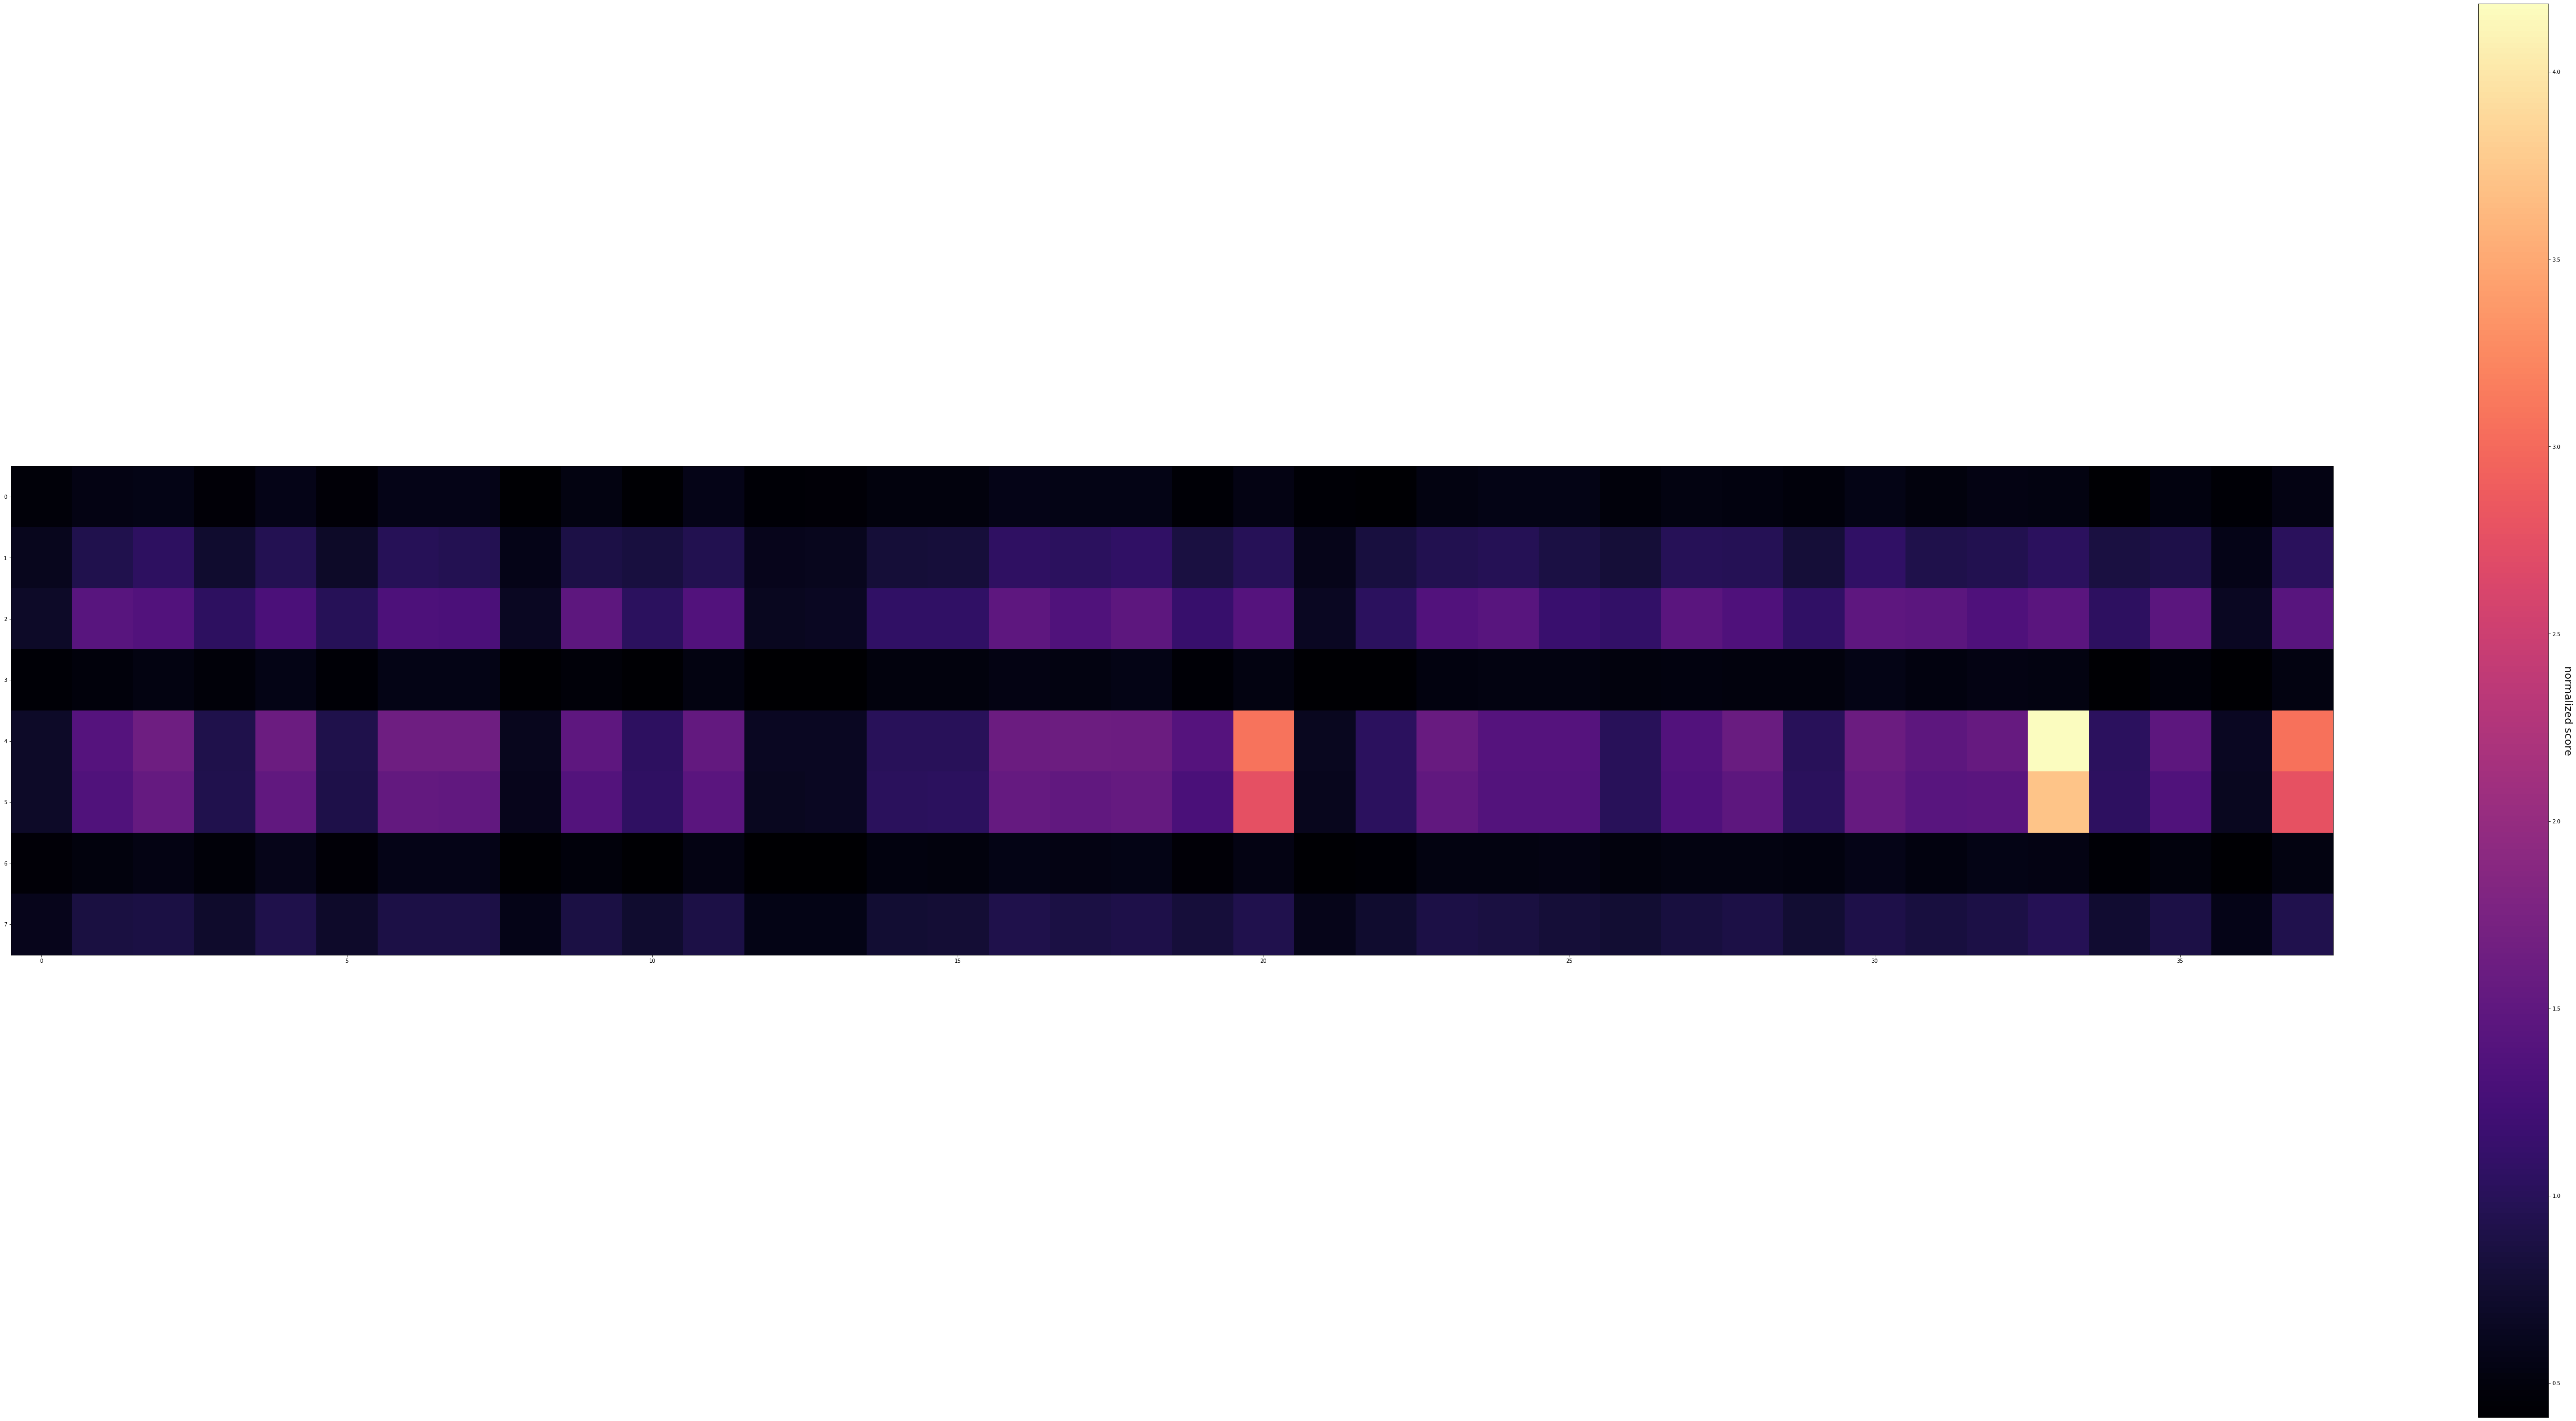

In [81]:
fig, ax = plt.subplots(figsize=(100,50))#300*0.5,200*0.5))
fontsize=20
im, cbar = heatmap(scrmtrx, cols, index, fontsize, ax=ax,
                   cmap="magma", cbarlabel="normalized score")
texts = annotate_heatmap(im, fontsize, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [49]:
fig.savefig("prova.pdf", format="pdf")